In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
import os
import random

In [5]:
PATH = "data/seedlings/"
sz=224
bs=32

In [6]:
# if not os.path.exists(f'{PATH}valid'):
#     os.makedirs(f'{PATH}valid')

# train_path=f'{PATH}train/'
# dirlist = [ item for item in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, item)) ]

# for dir_index in range(len(dirlist)):
#     if not os.path.exists(f'{PATH}valid/{dirlist[dir_index]}'):
#         os.makedirs(f'{PATH}valid/{dirlist[dir_index]}')
        
#     src_path = f'{PATH}train/{dirlist[dir_index]}/'
#     dst_path = f'{PATH}valid/{dirlist[dir_index]}/'
    
#     list_src = os.listdir(src_path)
#     number_files = len(list_src)
#     number_to_extract = int(.3 * number_files)
    
#     for file_index in range(number_to_extract):
#         random_filename = random.choice([
#             x for x in os.listdir(src_path)
#             if os.path.isfile(os.path.join(src_path, x))
#         ])
#         shutil.move(src_path + str(random_filename), dst_path + str(random_filename))
    

In [7]:
torch.cuda.is_available()

True

In [8]:
torch.backends.cudnn.enabled

True

In [9]:
os.listdir(PATH)

['zip_files',
 'train',
 'tmp',
 'test',
 'valid',
 'models',
 'sample_submission.csv']

In [10]:
os.listdir(f'{PATH}valid')

['maize',
 'common-wheat',
 'sugar-beet',
 'common-chickweed',
 'charlock',
 'shepherds-purse',
 'cleavers',
 'loose-silky-bent',
 'small-flowered-cranesbill',
 'fat-hen',
 'scentless-mayweed',
 'black-grass']

In [11]:
files = os.listdir(f'{PATH}valid/sugar-beet')[:5]
files

['e81a8dacb.png',
 '905ce5eb9.png',
 '728642410.png',
 '82b9d0a49.png',
 '88036eac5.png']

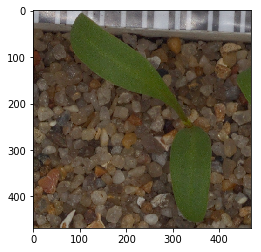

In [12]:
img = plt.imread(f'{PATH}valid/sugar-beet/{files[0]}')
plt.imshow(img);

In [13]:
img.shape

(468, 468, 3)

In [14]:
img[:4,:4]

array([[[0.75294, 0.72549, 0.7098 ],
        [0.64314, 0.61961, 0.61176],
        [0.70588, 0.69804, 0.70196],
        [0.73725, 0.73725, 0.74902]],

       [[0.7451 , 0.72157, 0.71373],
        [0.65882, 0.64314, 0.63922],
        [0.68235, 0.67451, 0.68627],
        [0.72549, 0.72941, 0.74118]],

       [[0.62745, 0.60392, 0.60784],
        [0.60392, 0.59216, 0.6    ],
        [0.6549 , 0.6549 , 0.67059],
        [0.72157, 0.72157, 0.74118]],

       [[0.51373, 0.49412, 0.5098 ],
        [0.59216, 0.58431, 0.59608],
        [0.63922, 0.63922, 0.65882],
        [0.71373, 0.71765, 0.73725]]], dtype=float32)

# 2.  Initial Model

In [15]:
arch=resnet50

In [ ]:
data = ImageClassifierData.from_paths(PATH, bs, tfms=tfms_from_model(arch, sz), trn_name = 'train', 
                                      val_name = 'valid', test_name = 'test')

learn = ConvLearner.pretrained(arch, data, precompute=True)

In [ ]:
learn.fit(0.1, 10)

## Choosing a learning rate

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [ ]:
lrf=learn.lr_find()

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.sched.plot()

## Improving the model
### Data Augementation - Set precompute to False so that data augmentation can take effect

In [16]:
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), trn_name = 'train', 
                                      val_name = 'valid', test_name = 'test', num_workers=4)
    
    return data if sz>300 else data.resize(340, 'tmp')

In [17]:
data = get_data(sz,bs)

In [18]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [19]:
learn.fit(.1, 10, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.414898   0.801921   0.732394  
    1      1.036127   0.628964   0.792254                 
    2      0.929478   0.610533   0.791549                  
    3      1.08125    0.721122   0.780986                  
    4      1.126264   0.738572   0.788028                 
    5      0.992394   0.656316   0.807746                  
    6      0.890979   0.660841   0.805634                  
    7      0.687252   0.605297   0.822535                  
    8      0.59579    0.538571   0.844366                  
    9      0.622172   0.596895   0.816901                  



[array([0.59689]), 0.8169014082828038]

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.save('224_lastlayer')

In [ ]:
learn.load('224_lastlayer')

### Increase Size - Increase the size of images in the data set

In [20]:
learn.set_data(get_data(280,bs))
learn.freeze()

In [21]:
learn.fit(.1, 3, cycle_len=1)

  0%|          | 0/53 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

### Fine Tuning - Unfreeze and retrain layers

In [ ]:
learn.unfreeze()

In [ ]:
lr=np.array([.001,.01,.1])

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save('224_all')

In [ ]:
learn.load('224_all')

### TTA - Test Time Augmentation

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [ ]:
accuracy_np(probs, y)

## Analyzing results

In [ ]:
# preds = np.argmax(probs, axis=1)
# probs = np.exp(log_preds[:,1])
# print(probs)

print(preds.shape())

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

# **Data Visualization**

In [ ]:
log_preds = learn.predict()
log_preds.shape

In [ ]:
log_preds[:10]

In [ ]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 11
probs = np.exp(log_preds[:,11])        # pr(Sugar beet)

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [ ]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [ ]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [ ]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [ ]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [ ]:
# This is the label for a val data
data.val_y

In [ ]:
# from here we know that 'Black-grass' is labeled 0 and 'Sugar beat' is labeled 11.
data.classes

In [ ]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [ ]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [ ]:
plot_val_with_title(most_by_correct(0, True), "Most correct Black-grass")

In [ ]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect Black-grass")

In [ ]:
plot_val_with_title(most_by_correct(1, True), "Most correct Charlock")

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect Charlock")

In [ ]:
plot_val_with_title(most_by_correct(2, True), "Most correct Cleavers")

In [ ]:
plot_val_with_title(most_by_correct(2, False), "Most incorrect Cleavers")

In [ ]:
plot_val_with_title(most_by_correct(3, True), "Most correct Chickweed")

In [ ]:
plot_val_with_title(most_by_correct(3, False), "Most incorrect Chickweed")

In [ ]:
plot_val_with_title(most_by_correct(4, True), "Most correct common wheat")

In [ ]:
plot_val_with_title(most_by_correct(4, False), "Most incorrect common wheat")

In [ ]:
plot_val_with_title(most_by_correct(5, True), "Most correct Fat Hen")

In [ ]:
plot_val_with_title(most_by_correct(5, False), "Most correct Fat Hen")

In [ ]:
plot_val_with_title(most_by_correct(6, True), "Most correct loose silky-bent")

In [ ]:
plot_val_with_title(most_by_correct(6, False), "Most incorrect loose silky-bent")

In [ ]:
plot_val_with_title(most_by_correct(7, True), "Most correct Maize")

In [ ]:
plot_val_with_title(most_by_correct(7, False), "Most incorrect Maize")

In [ ]:
plot_val_with_title(most_by_correct(8, True), "Most correct scentless mayweed")

In [ ]:
plot_val_with_title(most_by_correct(8, False), "Most incorrect scentless mayweed")

In [ ]:
plot_val_with_title(most_by_correct(9, True), "Most correct shepherds purse")

In [ ]:
plot_val_with_title(most_by_correct(9, False), "Most incorrect shepherds purse")

In [ ]:
plot_val_with_title(most_by_correct(10, True), "Most correct small flowered cranesbill")

In [ ]:
plot_val_with_title(most_by_correct(10, False), "Most incorrect small flowered cranesbill")

In [ ]:
plot_val_with_title(most_by_correct(11, True), "Most correct sugar beat")

In [ ]:
plot_val_with_title(most_by_correct(11, False), "Most incorrect sugar beat")